## _Inference after DNN Stage_

**_Inference_** is done using callbacks defined in the **_LightningModules/GNN/Models/inference.py_**. The callbacks run during the **_test_step()_** _a.k.a_ model _**evalution**_.

### How to run _Inference_?

1. _`traintrack config/pipeline_quickstart.yaml`_. One can use `--inference` flag to run only the `test_step()` (Should work, but failed.)
2. _`infer.ipynb`_ notebook runs the _pl.Trainer().test()_

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
from tqdm import tqdm
import trackml.dataset

In [4]:
import torch
import pytorch_lightning as pl
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import itertools

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
os.environ['EXATRKX_DATA'] = os.path.abspath(os.curdir)

In [7]:
from LightningModules.DNN import EdgeClassifier
from LightningModules.DNN import GNNMetrics

In [8]:
from LightningModules.DNN.Models.infer import GNNTelemetry

## _Classifier Evaluation_

Metrics to evaluate the GNN networks:

- Accuracy/ACC = $TP+TN/TP+TN+FP+FN$
- sensitivity, recall, hit rate, or true positive rate ($TPR = 1 - FNR$)
- specificity, selectivity or true negative rate ($TNR = 1 - FPR$)
- miss rate or false negative rate ($FNR = 1 - TPR$)
- fall-out or false positive rate ($FPR = 1 - TNR$)
- F1-score = $2 \times (\text{PPV} \times \text{TPR})/(\text{PPV} + \text{TPR})$
- Efficiency/Recall/Sensitivity/Hit Rate: $TPR = TP/(TP+FN)$
- Purity/Precision/Positive Predictive Value: $PPV = TP/(TP+FP$
- AUC-ROC Curve $\equiv$ FPR ($x-$axis) v.s. TPR ($y-$axis) plot
- AUC-PRC Curve $\equiv$ TPR ($x-$axis) v.s. PPV ($y-$axis) plot

### _(+) - Test Dataset_

In [9]:
# Test Dataset from GNNBuilder
inputdir="run/dnn_processed/test"
all_events = sorted(glob.glob(os.path.join(inputdir, "*")))

In [10]:
# Load Single Event
test_event = torch.load(all_events[0], map_location=device)

### _(+) - Load Checkpoint_

Lightning automatically saves a checkpoint for you in your current working directory, with the state of your last training epoch. We have checkpoint stored after training is finished.

```
# load a LightningModule along with its weights & hyperparameters from a checkpoint
model = MyLightningModule.load_from_checkpoint("/path/to/checkpoint.ckpt")
print(model.input_dir)
```

Note that we have saved our hyperparameters when our **LightningModule** was initialized i.e. `self.save_hyperparameters(hparams)`

```
# hyperparameters are saved to the “hyper_parameters” key in the checkpoint, to access them
checkpoint = torch.load(path/to/checkpoint, map_location=device)
print(checkpoint["hyper_parameters"])
```

One can also initialize the model with different hyperparameters (if they are saved).


For more details, consult [Lighting Checkpointing](https://pytorch-lightning.readthedocs.io/en/stable/common/checkpointing.html).

### _Get Hyperparameter Config File_

- Either from the configs folder 
- Or extract it from the checkpoint, favoured if model is trained and evaluated on two different machines.

In [11]:
# load processing config file (trusted source)
config = None
config_file = os.path.join(os.curdir, 'LightningModules/DNN/configs/train_alldata_DNN.yaml')
with open(config_file) as f:
    try:
        config = yaml.load(f, Loader=yaml.FullLoader) # equiv: yaml.full_load(f)
    except yaml.YAMLError as e:
        print(e)

In [12]:
# print(config)

In [13]:
# Load Model Checkpoint
ckpnt_path = "run/lightning_models/lightning_checkpoints/DNNStudy/version_0/checkpoints/last.ckpt"
checkpoint = torch.load(ckpnt_path, map_location=device)
config = checkpoint["hyper_parameters"]

In [14]:
print(checkpoint["hyper_parameters"])

{'input_dir': '/global/cscratch1/sd/aakram/run_all/feature_store', 'output_dir': '/global/cscratch1/sd/aakram/run_all/dnn_processed', 'project': 'DNNStudy', 'edge_cut': 0.5, 'pt_signal_min': 0.0, 'pt_background_min': 0.0, 'datatype_names': ['train', 'val', 'test'], 'datatype_split': [90000, 5000, 5000], 'train_split': [90000, 5000, 5000], 'sorted_events': True, 'noise': False, 'overwrite': True, 'spatial_channels': 3, 'cell_channels': 0, 'hidden': 128, 'n_graph_iters': 8, 'nb_node_layer': 3, 'nb_edge_layer': 3, 'emb_channels': 0, 'layernorm': True, 'aggregation': 'sum_max', 'hidden_activation': 'ReLU', 'weight': 2, 'warmup': 200, 'lr': 0.001, 'factor': 0.3, 'patience': 10, 'regime': 'pid', 'max_epochs': 40, 'callbacks': ['GNNTelemetry', 'GNNBuilder'], 'resume_id': 'version_0', 'logger': 'tb', 'model_library': 'LightningModules', 'artifact_library': '/global/cscratch1/sd/aakram/run/lightning_models/lightning_checkpoints', 'set': 'DNN', 'name': 'EdgeClassifier', 'config': 'train_alldata_

In [15]:
# View Hyperparameters
# print(config)

In [16]:
# One Can Modify Hyperparameters
config["checkpoint_path"] = ckpnt_path
config["input_dir"] = "run/feature_store"
config["output_dir"] = "run/dnn_processed"
config["artifact_library"] = "lightning_models/lightning_checkpoints"
config["train_split"] = [0, 0, 5000]
config["map_location"] = device

In [17]:
# View Hyperparameters (Modified)
# print(config)

In [18]:
# Init EdgeClassifier with New Config
model = EdgeClassifier(config)

In [19]:
# Load Checkpoint with New Config (It will Provide Path and Other Parameters, Most will be Overwritten)
model = model.load_from_checkpoint(**config)

In [20]:
# Lightning Trainer
trainer = pl.Trainer(callbacks=[GNNTelemetry()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Loading data to 'cpu'
Trainset: 90000, Valset: 5000, Testset: 5000



Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
preds: torch.Size([7801328]), truth: torch.Size([7801328])


[{}]

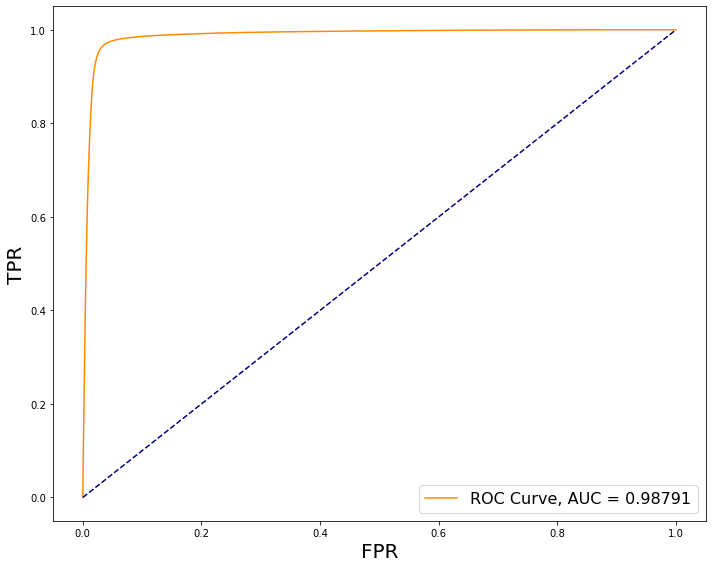

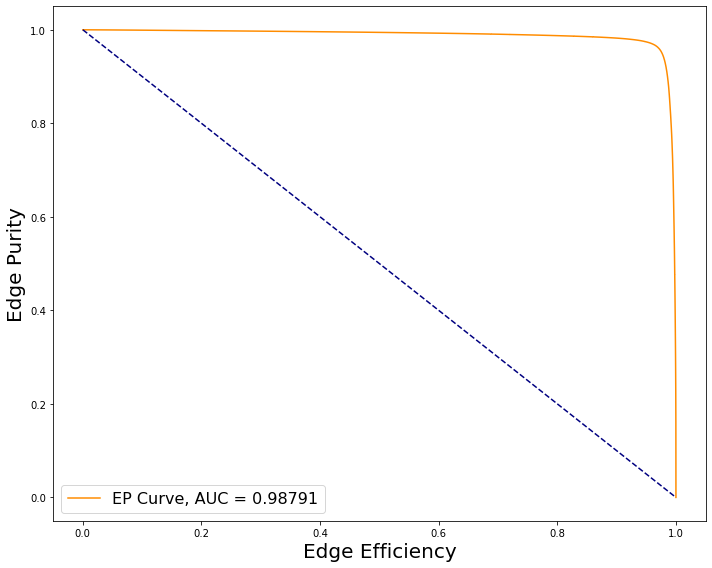

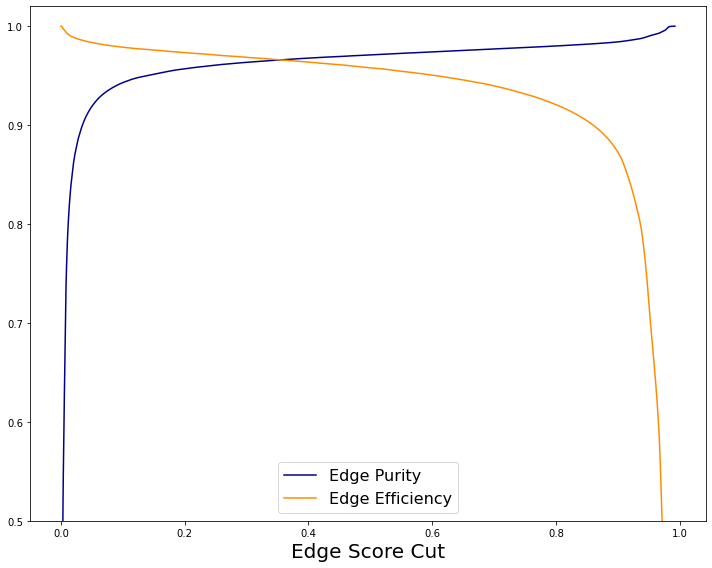

In [21]:
# Run Test Loop
trainer.test(model=model, dataloaders=None, ckpt_path=None, verbose=True, datamodule=None)

### _Test with LightningDataModule_

In [22]:
from LightningModules.DNN.utils.data_utils import split_datasets, load_dataset

In [23]:
class SttDataModule(pl.LightningDataModule):
    def __init__(self, hparams):
        super().__init__()

        # Set workers from hparams
        self.n_workers = (
            self.hparams["n_workers"]
            if "n_workers" in self.hparams
            else len(os.sched_getaffinity(0))
        )

        # Instance Variables
        self.train_split = self.hparams["train_split"]
        self.trainset, self.valset, self.testset = None, None, None

    def setup(self, stage: str):

        if stage == "fit":
            self.trainset, self.valset, self.testset = split_datasets(**self.hparams)

        if stage == "test":
            print("Number of Test Events: ", self.hparams["train_split"][2])
            self.testset = load_dataset(self.hparams["input_dir"], self.train_split[2])

    def train_dataloader(self):
        if self.trainset is not None:
            return DataLoader(
                self.trainset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

    def val_dataloader(self):
        if self.valset is not None:
            return DataLoader(
                self.valset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

    def test_dataloader(self):
        if self.testset is not None:
            return DataLoader(
                self.testset, batch_size=1, num_workers=self.n_workers
            )  # , pin_memory=True, persistent_workers=True)
        else:
            return None

In [24]:
# Prepare LightningDataModule (Error)
# dm = SttDataModule(config)

In [25]:
# dm.setup(stage='test')

In [26]:
# test_dataloaders = dm.test_dataloader

In [27]:
# trainer.test(model=model, dataloaders=None, ckpt_path=None, verbose=True, datamodule=dm)